In [1]:
!pip install us
!pip install geopandas
!pip install raster2xyz
import geopandas
import us
import ee
from IPython.display import Image
from google.colab import drive
import json
import time
import matplotlib.pyplot as plt
import pandas as pd
from raster2xyz.raster2xyz import Raster2xyz
from osgeo import gdal
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from shapely.geometry import shape, Point

     |████████████████████████████████| 132 kB 6.2 MB/s 
  Created wheel for us: filename=us-2.0.2-py3-none-any.whl size=11942 sha256=0bcf53981003d33876cb5998da9b3c306cda1ed1bd3b6db1d93b0e05e7051dc7
  Stored in directory: /root/.cache/pip/wheels/ca/6b/11/cda9ea2438f721330a35c9a2c8e34b4aedcd34c89af48a4d00
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp37-cp37m-linux_x86_64.whl size=72190 sha256=ce1363948a9128c09dcb63ef642c601b09eef2defcb101d5b4df0ee433638418
  Stored in directory: /root/.cache/pip/wheels/a1/99/51/7de469e37cd1b3c763c24394e1ebf1baa2d79e094bf346cf80
Successfully built us jellyfish
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 6.3 MB 36.8 MB/s 
  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5965 sha256=55da82400fca16cadf56c86e5945441274ef57eafee27fd26ed0596e845ce985
  Stored in directory: /root/.cache/pip/wheels/07/4b/5d/fc6

Source on using Earth Engine:
https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/intro-to-python-api-guiattard/index.ipynb|

In [2]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=nmArFseoUFtFIS5QvvrLx2H3LTZMlm-gU7qelPn5i5c&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjTDty0ZNQVGKrk1tDj6et42meuG4IAzYQRDXwO8iH5CAXpM9JnU1g

Successfully saved authorization token.


In [3]:
ee.Initialize()

#### I got a geojson file from this link <link><https://eric.clst.org/tech/usgeojson/> for the state outlines. This will be used for querying from Earth Engine

In [4]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [5]:
%cd /content/drive/Shareddrives/Data606_Energy/data/weather

/content/drive/Shareddrives/Data606_Energy/data/weather


## Get the US geojson outline and the state geojson outlines

In [6]:
with open('gz_2010_us_040_00_20m.json') as state_outlines_file:
  state_outlines = json.load(state_outlines_file)

In [7]:
data = geopandas.read_file("https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA.geo.json")

In [8]:
data.head()

,id,name,geometry
0,USA,United States of America,"MULTIPOLYGON (((-155.54211 19.08348, -155.6881..."


In [9]:
all_us_polygons = []
for poly in data['geometry'][0].geoms:
  x, y = poly.exterior.coords.xy
  all_us_polygons.append([[[x[i],y[i]] for i in range(len(x))]])

In [10]:
us_polygon = ee.Geometry.MultiPolygon(all_us_polygons)

In [11]:
states_coordinates = {}
ee_state_polygons = {}
for geom in state_outlines['features']:
  # get the abbreviation of the state before storing the coordinates
  geom_state = geom['properties']['NAME']
  state_object = us.states.lookup(geom_state)
  ee_state_polygons[state_object.abbr] = ee.Geometry.MultiPolygon(geom['geometry']['coordinates'],None, False)
  states_coordinates[state_object.abbr] = geom['geometry']['coordinates']

In [12]:
#this function is used to figure out which coordinates are within a polygon
def determine_within(coords,polygon):
  within = []
  for c in coords:
    p = Point(c[0],c[1])
    if polygon.contains(p):
      within.append(True)
    else:
      within.append(False)
  return within

In [13]:
# this function finds what states the data points belong to
def add_states_to_data(geojson, data):
  coordinates = [[data['x'].iloc[i], data['y'].iloc[i]] for i in range(data.shape[0])]
  data['State'] = [np.nan]*data.shape[0]
  shapely_polies = []
  states = []
  for p in geojson['features']:
    shapely_polies.append(shape(p['geometry']))
    states.append(p['properties']['NAME'])
  # now loop all the coordinates through these polygons and find which ones belong where
  for i, state_shape in enumerate(shapely_polies):
    coordinates_within_state = determine_within(coordinates, state_shape)
    data['State'].iloc[np.where(coordinates_within_state)] = states[i]
  return data

In [14]:
# does what it says - takes in a geotiff file path and makes it into a csv
def convert_geotiff_to_csv(file_path, output_path, start_date, delta, geojson):
  ds = gdal.Open(file_path)
  all_bands = []
  band_names = []
  data = {}
  # loop through each band
  print("There are {} dates of data".format(ds.RasterCount))
  for bi in range(ds.RasterCount):
      band = ds.GetRasterBand(bi + 1)
      #band_names.append(band.GetDescription())
      band_names.append(start_date)
      data[band.GetDescription()] = []
      # Read this band into a 2D NumPy array
      ar = band.ReadAsArray()
      all_bands.append(ar)
      start_date += delta
  x_range = len(all_bands[0])
  y_range = len(all_bands[0][0])
  # get the transform of the geotiff so we can get the coordinates of each pixel
  transform = ds.GetGeoTransform()
  xOrigin = transform[0]
  yOrigin = transform[3]
  pixelWidth = transform[1]
  pixelHeight = -transform[5]
  x_coordinates = np.arange(y_range)*pixelWidth+xOrigin
  y_coordinates = (np.arange(x_range)*pixelHeight-yOrigin)*-1
  all_coords = [(y,x) for y in y_coordinates for x in x_coordinates]
  # create a dictionary of data per band of data and make a pandas dataframe
  new_data = {}
  for i, band in enumerate(all_bands):
    new_data[band_names[i]] = np.array(band).flatten()
  new_data_pd = pd.DataFrame(new_data,index=all_coords)
  new_data_pd['y'] = [ind[0] for ind in new_data_pd.index]
  new_data_pd['x'] = [ind[1] for ind in new_data_pd.index]

  # now add the state of each coordinate to the data
  new_data_pd = add_states_to_data(geojson,new_data_pd)

  # now that I have the data with associated states, let's subset the data to coordinates that
  # within the US (the rest should be N/A anyway)
  new_data_pd = new_data_pd[~new_data_pd['State'].isnull()]

  # save the dataframe to a csv file
  new_data_pd.to_csv(output_path)
  return new_data_pd

## Get Temperature Data

In [15]:
granularity = 60000 # 60,000 m, so 60 km

In [16]:
date = ['1981-01-01','2021-10-01'] # range of dates to gather data for

In [17]:
state_poly = us_polygon # querying the entire US

In [18]:
temp = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY').select('temperature_2m').filter(ee.Filter.date(date[0],date[1]))#NASA/ORNL/DAYMET_V4 # OREGONSTATE/PRISM/AN81d # ECMWF/ERA5_LAND/MONTHLY
new_temp = temp.toBands().clip(state_poly)

task = ee.batch.Export.image.toDrive(image=new_temp,
                                    region = state_poly,
                                    scale = granularity,
                                    description='temp_layer'+date[0]+"-"+date[1],
                                    folder = './', # I could never get this to actually save to a specified folder
                                    fileNamePrefix='temp_layer'+date[0]+"-"+date[1],
                                    crs='EPSG:4326',
                                    fileFormat='GeoTiff')
task.start()
#now I'm putting in a while loop to wait until the task is completed and then it will move on to the next date range
completed = False
while not completed:
  if task.status()['state'] == 'COMPLETED':
    print("EXPORT COMPLETED. Onto the next date range")
    completed = True
  else:
    print("Export Not Completed. Waiting 10 more seconds")
    time.sleep(10)

Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
EXPORT COMPLETED. Onto the next date range


In [19]:
##quick visualization of the temp data for one of the days
Image(url=temp.first().clip(state_poly).getThumbURL({
    'min': 240, 'max': 300, 'dimensions': 512, 'region': state_poly,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [22]:
temperature_data_pd = convert_geotiff_to_csv('temp_layer{}-{}.tif'.format(date[0],date[1]), 'temperatures_{}-{}.csv'.format(date[0],date[1]),datetime(year=1981,month=1,day=1),relativedelta(months=1),state_outlines)

There are 486 dates of data


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [23]:
temperature_data_pd.shape

(3776, 489)

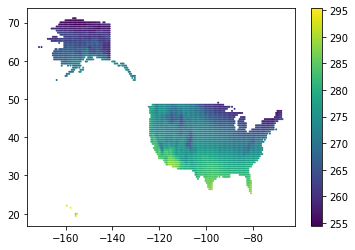

In [24]:
# confirm that the data looks correct
plt.scatter(temperature_data_pd['x'],temperature_data_pd['y'],c=temperature_data_pd[temperature_data_pd.columns[0]],s=1)
plt.colorbar()

## Get the Drought Data

In [21]:
temp = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').select('pdsi').filter(ee.Filter.date(date[0],date[1]))# GRIDMET/DROUGHT
new_temp = temp.toBands().clip(state_poly)

task = ee.batch.Export.image.toDrive(image=new_temp,
                                    region = state_poly,
                                    scale = granularity,
                                    description='pdsi_layer'+date[0]+"-"+date[1],
                                    folder = './',
                                    fileNamePrefix='pdsi_layer'+date[0]+"-"+date[1],
                                    crs='EPSG:4326',
                                    fileFormat='GeoTiff')
task.start()
#now I'm putting in a while loop to wait until the task is completed and then it will move on to the next date range
completed = False
while not completed:
  if task.status()['state'] == 'COMPLETED':
    print("EXPORT COMPLETED. Onto the next date range")
    completed = True
  else:
    print("Export Not Completed. Waiting 10 more seconds")
    time.sleep(10)

Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
EXPORT COMPLETED. Onto the next date range


In [25]:
drought_data_pd = convert_geotiff_to_csv('pdsi_layer{}-{}.tif'.format(date[0],date[1]), 'pdsi_{}-{}.csv'.format(date[0],date[1]),datetime(year=1981,month=1,day=1),relativedelta(months=1),state_outlines)

There are 480 dates of data


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [28]:
drought_data_pd.shape

(3776, 483)

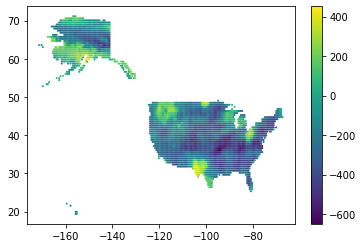

In [29]:
# confirm that the data looks correct
plt.scatter(drought_data_pd['x'],drought_data_pd['y'],c=drought_data_pd[drought_data_pd.columns[0]],s=1)
plt.colorbar()